In [3]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./metro_interstate_traffic_volume_preprocessed.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df["holiday"])
df["cat_holiday"] = le.transform(df["holiday"])
print(list(le.classes_))
df = df.drop(['holiday'], axis=1)

le.fit(df["weather_main"])
df["cat_weather_main"] = le.transform(df["weather_main"])
print(list(le.classes_))
df = df.drop(['weather_main'], axis=1)

le.fit(df["weather_description"])
df["cat_weather_description"] = le.transform(df["weather_description"])
print(list(le.classes_))
df = df.drop(['weather_description'], axis=1)

['Christmas Day', 'Columbus Day', 'Independence Day', 'Labor Day', 'Martin Luther King Jr Day', 'Memorial Day', 'New Years Day', 'None', 'State Fair', 'Thanksgiving Day', 'Veterans Day', 'Washingtons Birthday']
['Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain', 'Smoke', 'Snow', 'Squall', 'Thunderstorm']
['SQUALLS', 'Sky is Clear', 'broken clouds', 'drizzle', 'few clouds', 'fog', 'freezing rain', 'haze', 'heavy intensity drizzle', 'heavy intensity rain', 'heavy snow', 'light intensity drizzle', 'light intensity shower rain', 'light rain', 'light rain and snow', 'light shower snow', 'light snow', 'mist', 'moderate rain', 'overcast clouds', 'proximity shower rain', 'proximity thunderstorm', 'proximity thunderstorm with drizzle', 'proximity thunderstorm with rain', 'scattered clouds', 'shower drizzle', 'shower snow', 'sky is clear', 'sleet', 'smoke', 'snow', 'thunderstorm', 'thunderstorm with drizzle', 'thunderstorm with heavy rain', 'thunderstorm with light drizzle', 'thunderst

In [6]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [7]:
print(tf.__version__)

2.10.0


In [8]:
tf.random.set_seed(42)
np.random.seed(42)

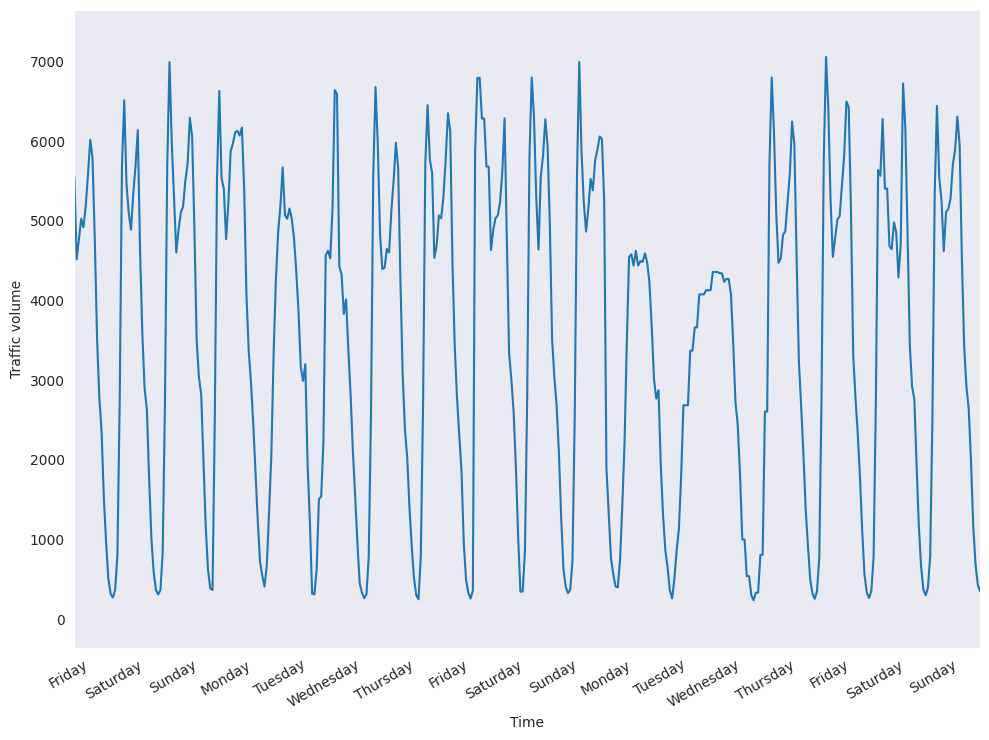

In [9]:
fig, ax = plt.subplots()

ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

In figure 12.4 you’ll notice clear daily seasonality, since the traffic volume is lower at the start and end of each day. You’ll also see a smaller traffic volume during the weekends. As for the trend, two weeks of data is likely insufficient to draw a reasonable conclusion, but it seems that the volume is neither increasing nor decreasing over time in the figure.

We can also plot the hourly temperature, as it will be a target for our multioutput models. Here, we’ll expect to see both yearly and daily seasonality. The yearly seasonality should be due to the seasons in the year, while the daily seasonality will be due to the fact that temperatures tend to be lower at night and higher during the day.

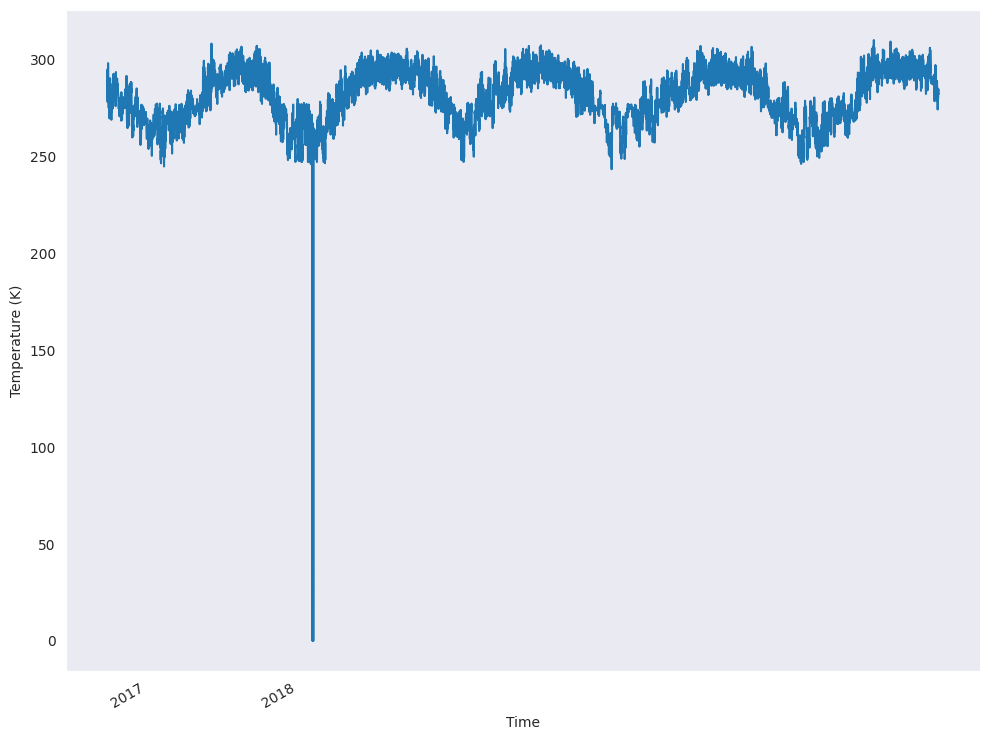

In [10]:
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()

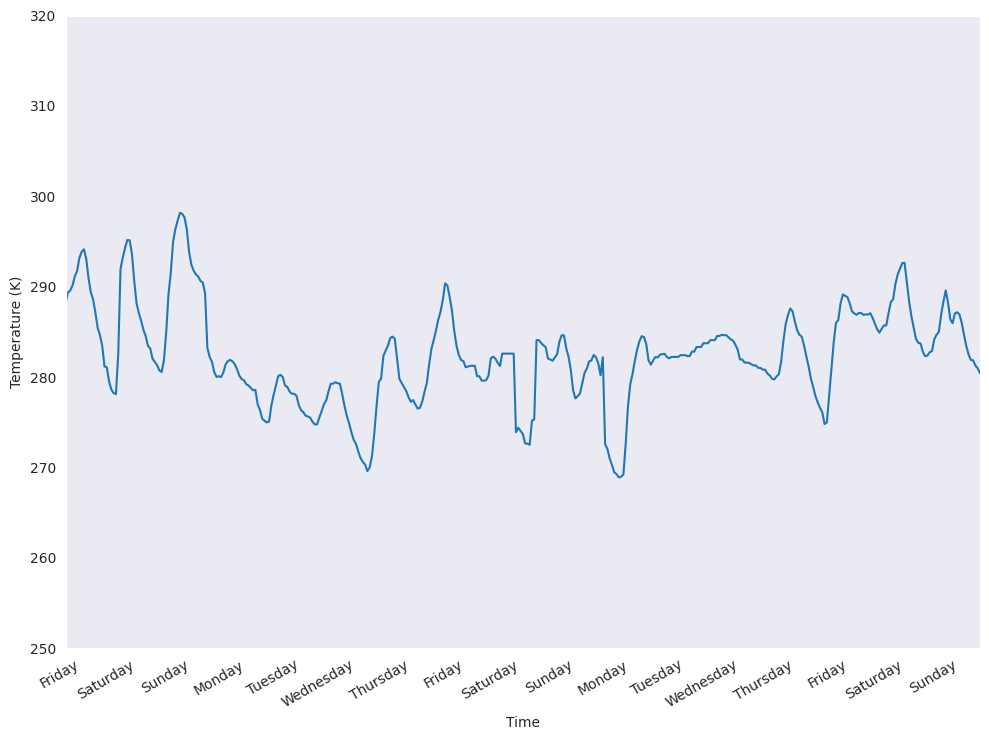

In [11]:
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)
plt.ylim(250,320)

fig.autofmt_xdate()
plt.tight_layout()

### 12.3.2 Feature engineering and data splitting

A great way to study the features of a dataset is to use the describe method from pandas. This method returns the number of records for each feature, allowing us to quickly identify missing values, the mean, standard deviation, quartiles, and maximum and minimum values for each feature.

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.205870,13.338232,0.0,272.16,282.45,291.806,310.07
rain_1h,48204.0,0.334264,44.789133,0.0,0.00,0.00,0.000,9831.30
snow_1h,48204.0,0.000222,0.008168,0.0,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.0,1.00,64.00,90.000,100.00
traffic_volume,48204.0,3259.818355,1986.860670,0.0,1193.00,3380.00,4933.000,7280.00
cat_holiday,48204.0,6.997780,0.139999,0.0,7.00,7.00,7.000,11.00
cat_weather_main,48204.0,2.578375,2.784224,0.0,0.00,1.00,5.000,10.00
cat_weather_description,48204.0,16.540536,8.970108,0.0,10.00,17.00,27.000,37.00


From the output, you’ll notice that rain_1h is mostly 0 throughout the dataset, as its third quartile is still at 0. Since at least 75% of the values for rain_1h are 0, it is unlikely that it is a strong predictor of traffic volume. Thus, this feature will be removed.

Looking at snow_1h, you’ll notice that this variable is at 0 through the entire dataset. This is easily observable, since its minimum and maximum values are both 0. Thus, this is not predictive of the variation in traffic volume over time. This feature will also be removed from the dataset.

In [13]:
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

df.shape

(48204, 7)

Now we reach the interesting problem of encoding time as a usable feature for our deep learning models. Right now, the date_time feature is not usable by our models, since it is a datetime string. We will thus convert it into a numerical value.

A simple way to do that is to express the date as a number of seconds. This is achieved through the use of the timestamp method from the datetime library.

In [14]:
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

Unfortunately, we are not done, as this simply expresses each date in seconds, as shown in figure 12.7. This leads us to losing the cyclical nature of time, because the number of seconds simply increases linearly with time.

Therefore, we must apply a transformation to recover the cyclical behavior of time. A simple way to do that is to apply a sine transformation. We know that the sine function is cyclical, bounded between –1 and 1. This will help us regain part of the cyclical property of time.

In [15]:
day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

df = df.drop(['date_time'], axis=1)

With a single sine transformation, we regain some of the cyclical property that was lost when converting to seconds. However, at this point, 12 p.m. is equivalent to 12 a.m., and 5 p.m. is equivalent to 5 a.m. This is undesired, as we want to distinguish between morning and afternoon. Thus, we’ll apply a cosine transformation. We know that cosine is out of phase with the sine function. This allows us to distinguish between 5 a.m. and 5 p.m., expressing the cyclical nature of time in a day. At this point, we can remove the date_time column from the DataFrame.

We can quickly convince ourselves that these transformations worked by plotting a sample of day_sin and day_cos.

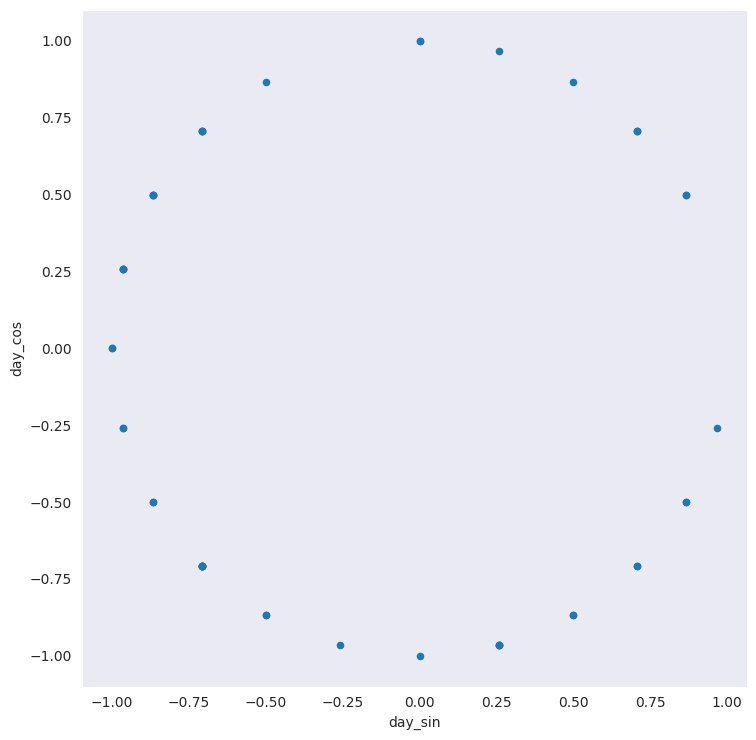

In [16]:
df.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');
plt.tight_layout()

In figure 12.8 you’ll notice that the points form a circle, just like a clock. Therefore, we have successfully expressed each timestamp as a point on the clock, meaning that we now have numerical values that retain the cyclical nature of time in a day, and this can be used in our deep learning models. This will be useful since we observed daily seasonality for both the temperature and the volume of traffic.

With the feature engineering complete, we can now split our data train, validation, and test sets. The train set is the sample of data used to fit the model. The validation set is a bit like a test set that the model can peek at to tune its hyperparameters and improve its performance during the model’s training. The test set is completely separate from the model’s training procedure and is used for an unbiased evaluation of the model’s performance.

Here we’ll use a simple 70:20:10 split for the train, validation, and test sets. While 10% of the data seems like a small portion for the test set, remember that we have more than 17,000 records, meaning that we will evaluate the model on more than 1,000 data points, which is more than enough.

In [19]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((33742, 8), (9641, 8), (4821, 8))

Before saving the data, we must scale it so all values are between 0 and 1. This decreases the time required for training deep learning models, and it improves their performance. We’ll use MinMaxScaler from sklearn to scale our data.

Note that we will fit the scaler on the training set to avoid data leakage. That way, we are simulating the fact that we only have the training data available when we’re using the model, and no future information is known by the model. The evaluation of the model remains unbiased.

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

It is worth mentioning why the data is scaled and not normalized. Scaling and normalization can be confusing terms for data scientists, as they are often used interchangeably.

In short, scaling the data affects only its scale and not its distribution. Thus, it simply forces the values into a certain range. In our case, we force the values to be between 0 and 1.

Normalizing the data, on the other hand, affects its distribution and its scale. Thus, normalizing the data would force it to have a normal distribution or a Gaussian distribution. The original range would also change, and plotting the frequency of each value would generate a classic bell curve.

Normalizing the data is only useful when the models we use require the data to be normal. For example, linear discriminant analysis (LDA) is derived from the assumption of a normal distribution, so it is better to normalize data before using LDA. However, in the case of deep learning, no assumptions are made, so normalizing is not required.

Finally, we’ll save each set as a CSV file for use in the following chapters.

In [22]:
train_df.to_csv('./train.csv')
val_df.to_csv('./val.csv')
test_df.to_csv('./test.csv')